In [94]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy

In [78]:
model_path = '../Modelo/MiBiciTuBici'
model_output_path = f'{model_path}/model-output'
processed_output_path = f'{model_path}/processed-model-output/'
experiment_1_path = f'{model_output_path}/experiment-1'
experiment_2_path = f'{model_output_path}/experiment-2'

# --> Sanity checks
if not os.path.exists(model_output_path) or len(os.listdir(model_output_path)) == 0:
    raise Exception('No model output is available. Run the AnyLogic experiment and try again.')
if not os.path.exists(experiment_1_path) or len(os.listdir(experiment_1_path)) == 0:
    raise Exception('No model output is available for experiment 1. Run the AnyLogic experiment and try again.')
if not os.path.exists(experiment_2_path) or len(os.listdir(experiment_2_path)) == 0:
    raise Exception('No model output is available for experiment 2. Run the AnyLogic experiment and try again.')

if not os.path.exists(processed_output_path):
    os.mkdir(processed_output_path)

experiment_1_files = os.listdir(experiment_1_path)
experiment_2_files = os.listdir(experiment_2_path)

for file in experiment_1_files:
    if not file.startswith('output') and not file.endswith('.json'):
        raise Exception(f'File {file} is not recognized. Aborting.')

for file in experiment_2_files:
    if not file.startswith('output') and not file.endswith('.json'):
        raise Exception(f'File {file} is not recognized. Aborting.')

n_replications = len(experiment_1_files)

statistics = (
    'co2Avoided',
)

results_exp_1 = { f'{statistic}': [] for statistic in statistics }
results_exp_2 = { f'{statistic}': [] for statistic in statistics }
results_difference = { f'{statistic}': [] for statistic in statistics }

In [79]:
correctos = []
defectuosos = []

for output_file in experiment_1_files:
    with open(f'{model_output_path}/experiment-1/{output_file}', 'r') as f:
        try:
            data = json.load(f)
            correctos.append(output_file)
        except:
            defectuosos.append(output_file)

    for statistic in statistics:
        results_exp_1[statistic].append(data[statistic])

print(len(correctos))
print(len(defectuosos))
defectuosos

123
0


[]

In [80]:
correctos = []
defectuosos = []

for output_file in experiment_2_files:
    with open(f'{model_output_path}/experiment-2/{output_file}', 'r') as f:
        try:
            data = json.load(f)
            correctos.append(output_file)
        except:
            defectuosos.append(output_file)

    for statistic in statistics:
        results_exp_2[statistic].append(data[statistic])

print(len(correctos))
print(len(defectuosos))
defectuosos

111
0


[]

In [81]:
print('-------------- experiment 1')
print(f'mean: {np.mean(results_exp_1["co2Avoided"])}')
print(f'std: {np.std(results_exp_1["co2Avoided"])}')
print(f'count: {len(results_exp_1["co2Avoided"])}')
print('-------------- experiment 2')
print(f'mean: {np.mean(results_exp_2["co2Avoided"])}')
print(f'std: {np.std(results_exp_2["co2Avoided"])}')
print(f'count: {len(results_exp_2["co2Avoided"])}')

-------------- experiment 1
mean: 244670.12046435926
std: 16535.307387228928
count: 123
-------------- experiment 2
mean: 247449.44440624164
std: 17275.657487051554
count: 111


# ----- Test de medias ----- 

In [95]:
co2Avoided_exp_1 = np.array(results_exp_1["co2Avoided"])
co2Avoided_exp_2 = np.array(results_exp_2["co2Avoided"])
if len(co2Avoided_exp_1)>len(co2Avoided_exp_2):
    co2Avoided_exp_1 = co2Avoided_exp_1[:len(co2Avoided_exp_2)]
else:
    co2Avoided_exp_2 = co2Avoided_exp_2[:len(co2Avoided_exp_1)]

print(len(co2Avoided_exp_1),len(co2Avoided_exp_2))


111 111


In [88]:
def mean_confidence_interval(data, confidence=0.95):
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        return m, m-h, m+h

In [113]:
# --> Confidence intervals for the difference
print('-> calculating confidence intervals for the difference of the realizations...')

results_difference = np.array(co2Avoided_exp_1 - co2Avoided_exp_2)

mean, lower, upper = mean_confidence_interval(results_difference)
confidence_intervals = (lower, mean, upper)

confidence_intervals = pd.DataFrame(confidence_intervals).transpose()
confidence_intervals.columns = ('Cota inferior', 'Media', 'Cota superior')
confidence_intervals = confidence_intervals.round(decimals=2)
#confidence_intervals.to_csv('../Modelo/MiBiciTuBici/processed-model-output/intervals.csv')
# ------------------------------------------
print(confidence_intervals, "    ", results_difference)

-> calculating confidence intervals for the difference of the realizations...
   Cota inferior    Media  Cota superior
0       -7743.42 -3285.84        1171.73      [ -6457.51258688  18139.83284883  -2154.34172787  -4339.34049743
  19569.83480592  -7139.5911259  -53951.02212694  30054.48451008
  -6142.64628491  -7557.14716696 -24948.76148401  -4670.21302326
  11129.03350479   3095.86226471 -12789.08789119 -26504.2119218
  -9260.25939593   5751.41050001 -16970.42992114  58370.09181576
  12811.09688405    798.47799839   7152.34917456 -30537.85459129
 -25507.71062517 -18621.4126613    3822.84066323  22869.3001363
  20473.66713789  29740.84737359  -7030.96972856 -13894.557749
 -28914.59852311   2716.6200487   13152.74249183  11936.68448753
   2749.5835635  -12586.11144259 -33381.53200813  -3112.47585036
  30089.75215134 -44616.36821676  15390.82449816 -32956.33085565
 -26823.1586861   14730.64807908 -26811.1757832   12887.45593883
   7100.03365686 -28170.53239819 -21503.02553817  28977.839

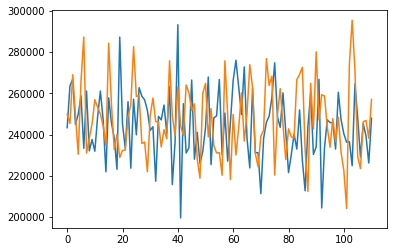

In [98]:
plt.plot(co2Avoided_exp_1)
plt.plot(co2Avoided_exp_2)

In [48]:
c=0
for i in results_exp_1["co2Avoided"]:
    if i==0:
        c+=1
print(c)

0


In [4]:
for output_file in experiment_2_files:
    with open(f'{model_output_path}/experiment-2/{output_file}') as f:
        data = json.load(f)

    stations_population_data_exp_2.append(data['estaciones'])

    for statistic in statistics:
        results_exp_2[statistic].append(data[statistic])

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf1 in position 185: invalid continuation byte

In [18]:
hasta = 3

s = np.std(results_exp_2['co2Avoided'][:hasta])
n = len(results_exp_2['co2Avoided'][:hasta])

print(s/np.sqrt(n))
print(1.96*s)

if s/np.sqrt(n) <= 1.96*s: 
    print('suficiente')

9839.43526856974
33403.1075337779
suficiente
